In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-prediction-dataset/traffic.csv


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import StratifiedKFold,GridSearchCV,RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold#For splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, r2_score, mean_absolute_error,mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',None)
#from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


In [22]:
df = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [23]:
df["DateTime"] = pd.to_datetime(df['DateTime'], utc = True)


df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['day_of_month'] = df['DateTime'].dt.day
#df['Hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['Date']= df['DateTime'].dt.date
df['Time']= df['DateTime'].dt.hour

df['day_of_year']=  df['DateTime'].dt.dayofyear
df['Seconds'] = pd.to_timedelta(df['DateTime'].dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)


In [24]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,day_of_year,Seconds
0,2015-11-01 00:00:00+00:00,1,15,20151101001,2015,11,1,6,2015-11-01,0,305,0
1,2015-11-01 01:00:00+00:00,1,13,20151101011,2015,11,1,6,2015-11-01,1,305,3600
2,2015-11-01 02:00:00+00:00,1,10,20151101021,2015,11,1,6,2015-11-01,2,305,7200
3,2015-11-01 03:00:00+00:00,1,7,20151101031,2015,11,1,6,2015-11-01,3,305,10800
4,2015-11-01 04:00:00+00:00,1,9,20151101041,2015,11,1,6,2015-11-01,4,305,14400


In [25]:
df.Year.unique()

array([2015, 2016, 2017])

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   DateTime      48120 non-null  datetime64[ns, UTC]
 1   Junction      48120 non-null  int64              
 2   Vehicles      48120 non-null  int64              
 3   ID            48120 non-null  int64              
 4   Year          48120 non-null  int64              
 5   Month         48120 non-null  int64              
 6   day_of_month  48120 non-null  int64              
 7   day_of_week   48120 non-null  int64              
 8   Date          48120 non-null  object             
 9   Time          48120 non-null  int64              
 10  day_of_year   48120 non-null  int64              
 11  Seconds       48120 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(10), object(1)
memory usage: 4.4+ MB


In [27]:
df.isnull().sum()

DateTime        0
Junction        0
Vehicles        0
ID              0
Year            0
Month           0
day_of_month    0
day_of_week     0
Date            0
Time            0
day_of_year     0
Seconds         0
dtype: int64

In [28]:
df.describe()

,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Time,day_of_year,Seconds
count,48120.000000,48120.000000,4.812000e+04,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000,48120.000000
mean,2.180549,22.791334,2.016330e+10,2016.269825,5.884289,15.700748,2.996010,11.500000,163.926185,41400.000000
std,0.966955,20.750063,5.944854e+06,0.616093,3.569872,8.784073,2.000017,6.922258,109.219475,24920.130527
min,1.000000,1.000000,2.015110e+10,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,9.000000,2.016042e+10,2016.000000,3.000000,8.000000,1.000000,5.750000,72.000000,20700.000000
50%,2.000000,15.000000,2.016093e+10,2016.000000,5.000000,16.000000,3.000000,11.500000,144.000000,41400.000000
75%,3.000000,29.000000,2.017023e+10,2017.000000,9.000000,23.000000,5.000000,17.250000,260.000000,62100.000000
max,4.000000,180.000000,2.017063e+10,2017.000000,12.000000,31.000000,6.000000,23.000000,366.000000,82800.000000


In [29]:
df.nunique()

DateTime        14592
Junction            4
Vehicles          141
ID              48120
Year                3
Month              12
day_of_month       31
day_of_week         7
Date              608
Time               24
day_of_year       366
Seconds            24
dtype: int64

In [30]:
df_corr = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=True).reset_index()
df_corr=df_corr.loc[(df_corr['level_0']=='Vehicles') & (df_corr['level_0']!=df_corr['level_1'])]
df_corr.columns = ['Target Feature', 'Input Features', 'Correlation Value']
df_corr.reset_index(inplace=True)
df_corr.drop('index', axis=1)

,Target Feature,Input Features,Correlation Value
0,Vehicles,day_of_year,0.020746
1,Vehicles,Month,0.022723
2,Vehicles,day_of_month,0.027895
3,Vehicles,day_of_week,0.126027
4,Vehicles,Seconds,0.219938
5,Vehicles,Time,0.219938
6,Vehicles,Year,0.221253
7,Vehicles,ID,0.227974
8,Vehicles,Junction,0.613787


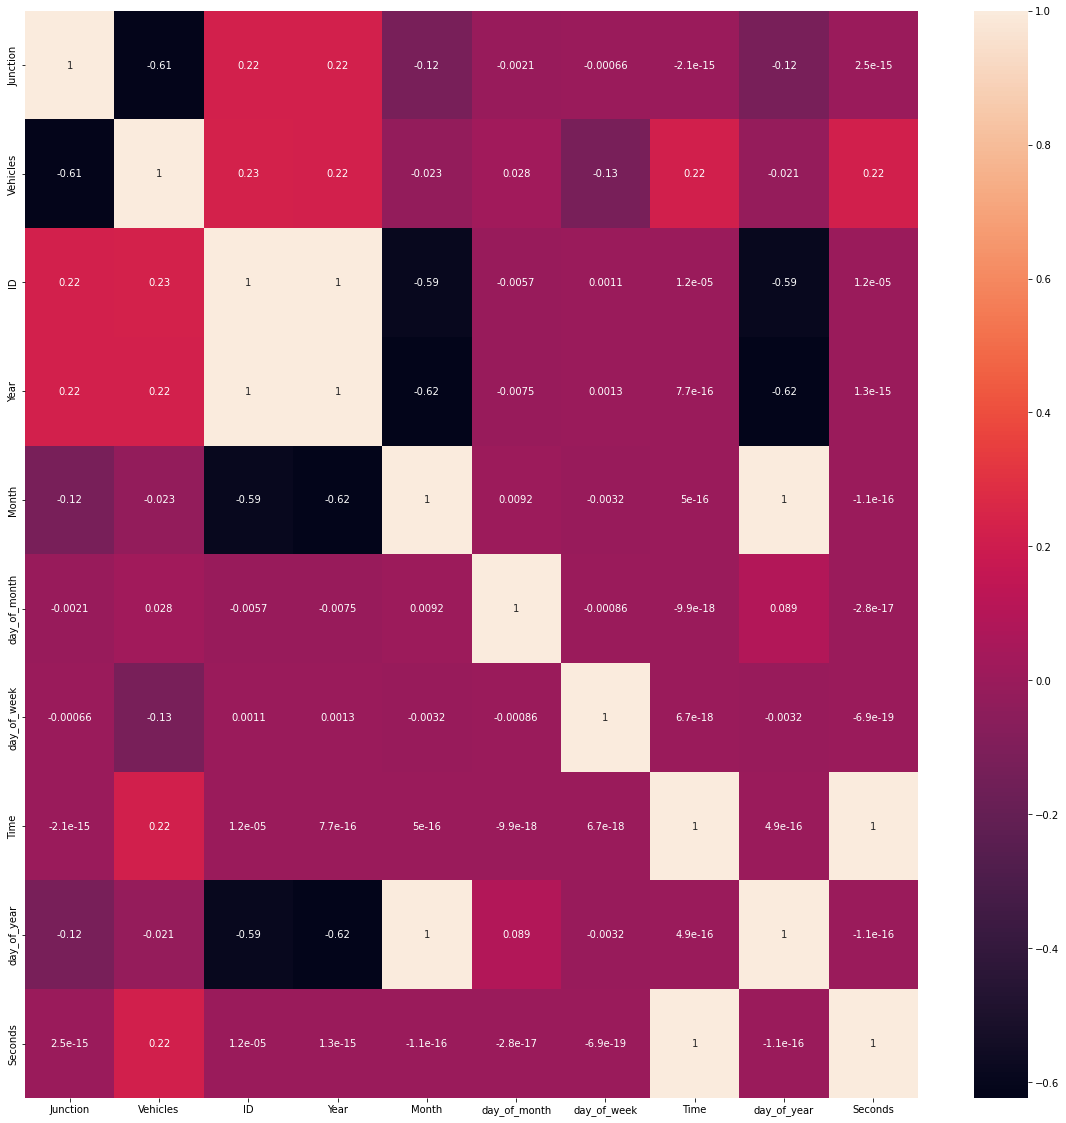

In [31]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [32]:
df.Year.unique()

array([2015, 2016, 2017])

### Extracting and Visualizing Total Vehicular Movement for each Junctions

In [33]:
df_junction = df.groupby(["Junction"])["Vehicles"].mean().reset_index(name = "Total_Vehicles")
df_junction

,Junction,Total_Vehicles
0,1,45.052906
1,2,14.253221
2,3,13.694010
3,4,7.251611


<AxesSubplot:title={'center':'Vehicular Movement By Junctions'}, xlabel='Junction', ylabel='Total Vehicles'>

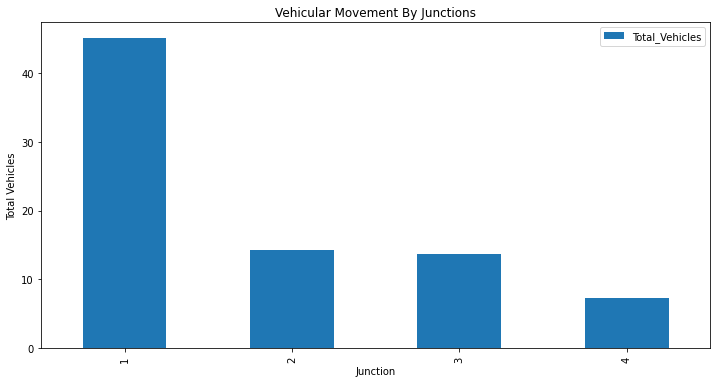

In [34]:
## Using Bar Chart to visualize vehicular movement per Junctions
df_junction.plot (x="Junction", y= "Total_Vehicles",
        kind="bar",
        figsize=(12,6),
        title="Vehicular Movement By Junctions",
        xlabel = "Junction", 
        ylabel = "Total Vehicles"
)


### Using a time series chart (Line Chart) to visualize vehicular movement volume for each junction for the duration under review

In [35]:
df_date = df.pivot_table(index = 'Date', columns = 'Junction', values = 'Vehicles', aggfunc = np.mean)
df_date.head()

Junction,1,2,3,4
Date,,,,
2015-11-01,13.625000,5.541667,5.666667,NaN
2015-11-02,22.750000,8.208333,6.916667,NaN
2015-11-03,22.666667,9.041667,6.250000,NaN
2015-11-04,20.750000,8.291667,5.041667,NaN
2015-11-05,19.333333,8.333333,4.416667,NaN


<AxesSubplot:xlabel='Date'>

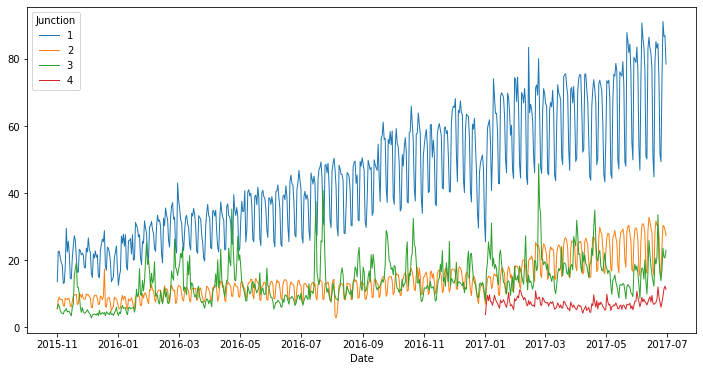

In [36]:
df_date.plot(kind='line', linewidth=1.0, figsize=(12, 6))

In [37]:
df_month = df.pivot_table(index = 'Month', columns = 'Junction', values = 'Vehicles', aggfunc = 'mean')
df_month

Junction,1,2,3,4
Month,,,,
1,41.249328,11.168011,12.879704,7.497312
2,46.000731,14.532895,15.565789,8.279762
3,46.590054,16.082661,14.770161,6.627688
4,46.865278,16.838194,18.793750,6.186111
5,51.899866,18.364247,12.675403,6.555108
6,55.079167,18.794444,13.004861,8.468056
7,39.127688,11.534946,14.850806,NaN
8,41.915323,11.071237,12.822581,NaN
9,47.741667,12.590278,16.602778,NaN


<AxesSubplot:xlabel='Month'>

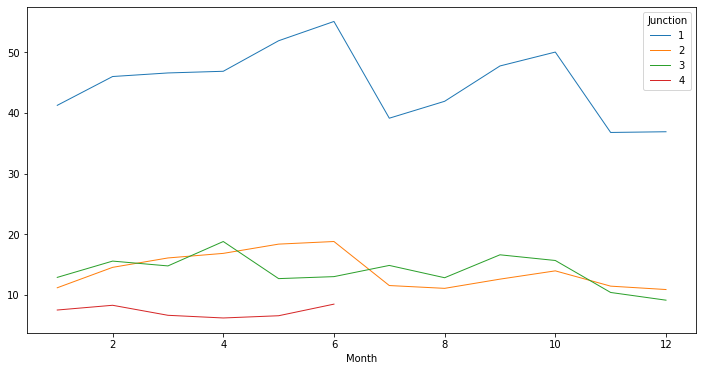

In [38]:
df_month.plot(kind='line', linewidth=1.0, figsize=(12, 6))

In [39]:
df_year = df.pivot_table(index = 'Year', columns = 'Junction', values = 'Vehicles', aggfunc = np.mean)
df_year

Junction,1,2,3,4
Year,,,,
2015,20.644126,8.351093,5.534836,NaN
2016,39.287113,11.731557,13.142077,NaN
2017,64.938076,21.341390,17.559853,7.251611


### Using a bar plot to compare rate of vehicular movement with year for each junction

<AxesSubplot:xlabel='Year'>

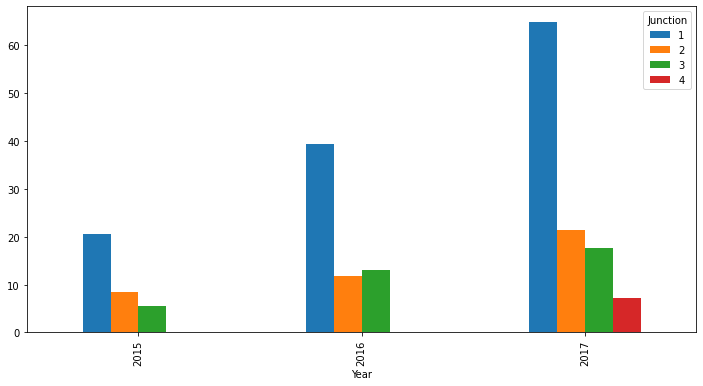

In [40]:
df_year.plot(kind='bar', linewidth=1.0, figsize=(12, 6))

### Visualizing Daily Traffic situation for each junctions

In [41]:
df_day = df.pivot_table(index = 'day_of_month', columns = 'Junction', values = 'Vehicles', aggfunc = np.mean)
df_day

Junction,1,2,3,4
day_of_month,,,,
1,42.781250,13.889583,13.487500,6.944444
2,44.864583,14.085417,14.066667,8.118056
3,44.150000,13.947917,13.181250,7.881944
4,42.391667,12.916667,12.666667,7.701389
5,42.847917,13.054167,12.893750,7.951389
6,44.983333,13.902083,12.154167,7.500000
7,43.822917,14.312500,12.077083,7.277778
8,45.197917,14.587500,11.458333,6.826389
9,46.154167,14.343750,13.185417,7.381944


<AxesSubplot:xlabel='day_of_month'>

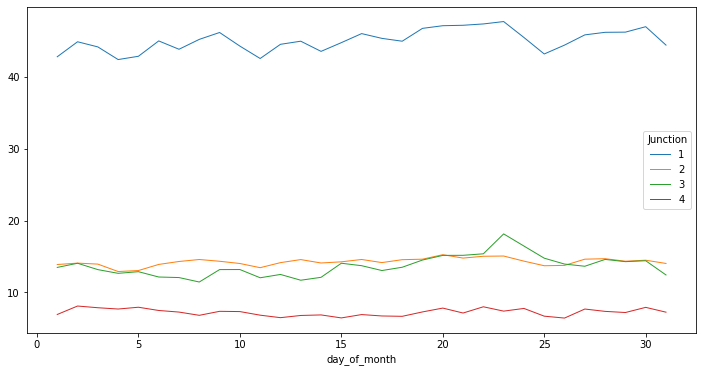

In [42]:
df_day.plot(kind='line', linewidth=1.0, figsize=(12, 6))

In [43]:
df_day1 = df.pivot_table(index = 'day_of_week', columns = 'Junction', values = 'Vehicles', aggfunc = np.mean)
df_day1

Junction,1,2,3,4
day_of_week,,,,
0,49.404215,15.228927,13.657567,7.469551
1,51.240900,16.556992,13.251916,7.921474
2,50.862548,16.416667,13.406130,7.628205
3,50.284483,16.026341,14.299330,7.915064
4,47.042146,14.942529,14.351054,7.307692
5,34.111919,10.412791,14.596899,6.546667
6,32.298372,10.144157,12.305556,5.945513


<AxesSubplot:xlabel='day_of_week'>

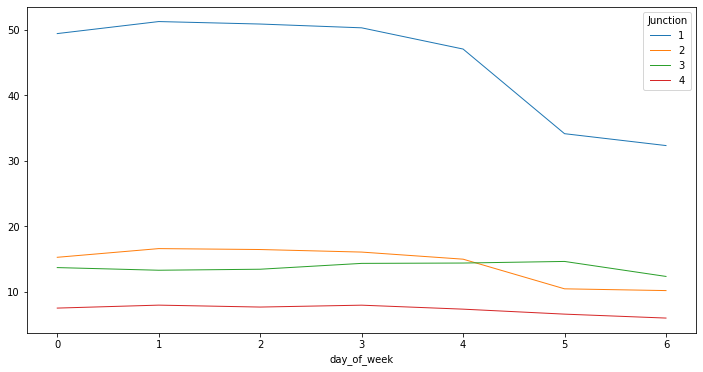

In [44]:
df_day1.plot(kind='line', linewidth=1.0, figsize=(12, 6))

### Visualizing Hourly Vehicular Movement for each Junction

In [45]:
df_time = df.pivot_table(index = 'Time', columns = 'Junction', values = 'Vehicles', aggfunc = np.mean)
df_time

Junction,1,2,3,4
Time,,,,
0,45.738487,15.656250,14.174342,6.922652
1,39.156250,14.115132,9.856908,5.668508
2,33.907895,12.995066,8.055921,4.839779
3,29.430921,11.468750,6.776316,4.320442
4,25.654605,10.000000,5.978618,3.856354
5,24.067434,9.217105,5.685855,3.944751
6,26.080592,9.263158,6.236842,4.110497
7,29.526316,10.064145,7.550987,4.519337
8,32.735197,10.745066,9.057566,5.220994


<AxesSubplot:xlabel='Time'>

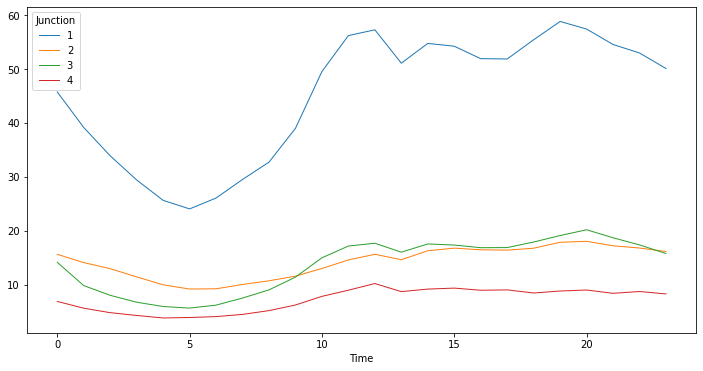

In [46]:
df_time.plot(kind='line', linewidth=1.0, figsize=(12, 6))

## Bivariate Analysis

In [47]:
def show_hist(junction=1):
    data = df[df['Junction'] == junction]
    f, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data['Vehicles'], kde=True, stat='probability')
    ax.set_title(f'Showing the Distribution of Vehicle Data  in Junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

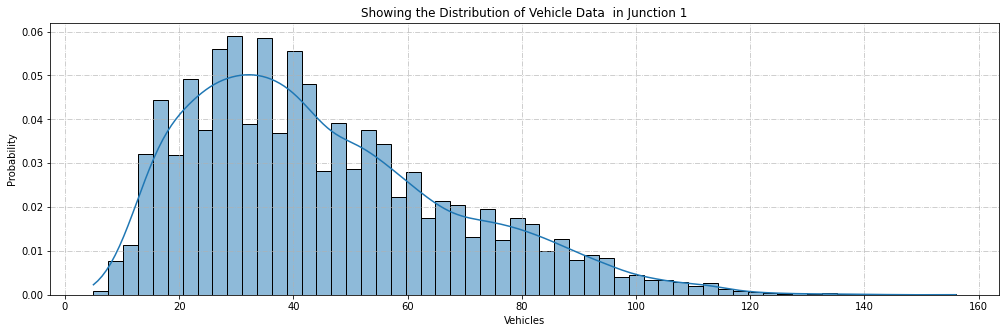

In [48]:
show_hist(1)

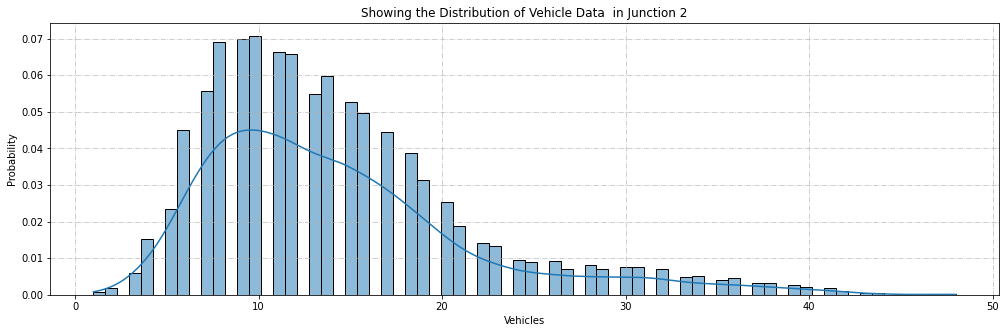

In [49]:
show_hist(2)

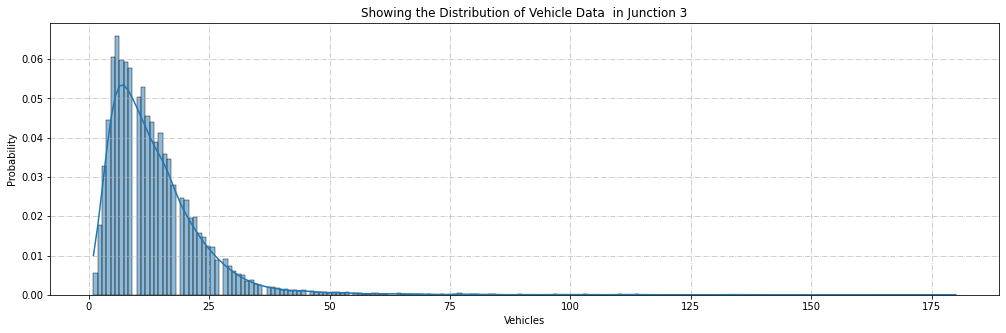

In [50]:
show_hist(3)

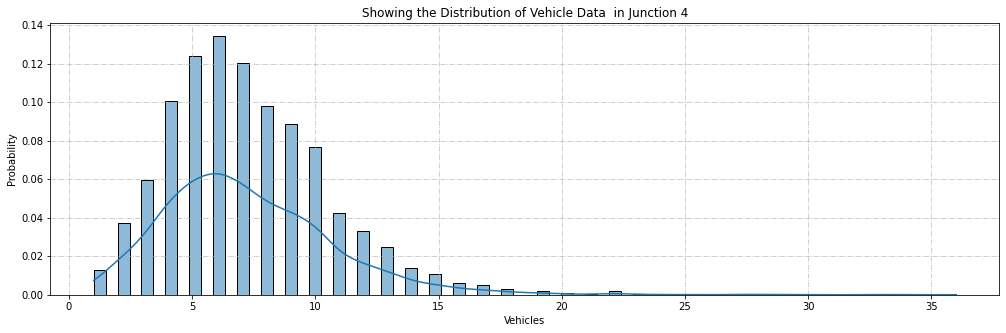

In [51]:
show_hist(4)

In [52]:
def td_time_series_plot(junction=1):
    f, ax = plt.subplots(figsize=(17, 5))
    data=df[df.Junction == junction]
    ax = sns.lineplot(data=data, y='Vehicles', x='DateTime', ax=ax)
    start = data.head(1).reset_index()
    end = data.tail(1).reset_index()
    ax.set_title(f'Plot show amounts of Vehicles in junction {junction} from {start.Month[0]}-{start.Year[0]} to {end.Month[0]}-{end.Year[0]}', fontsize=15)
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()

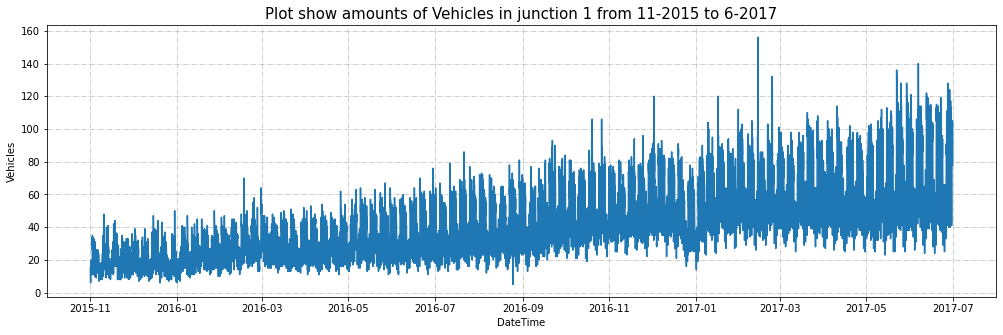

In [53]:
td_time_series_plot(1)

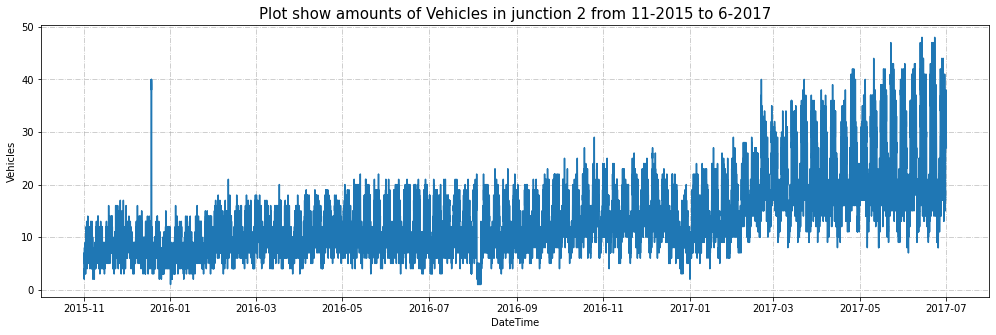

In [54]:
td_time_series_plot(2)

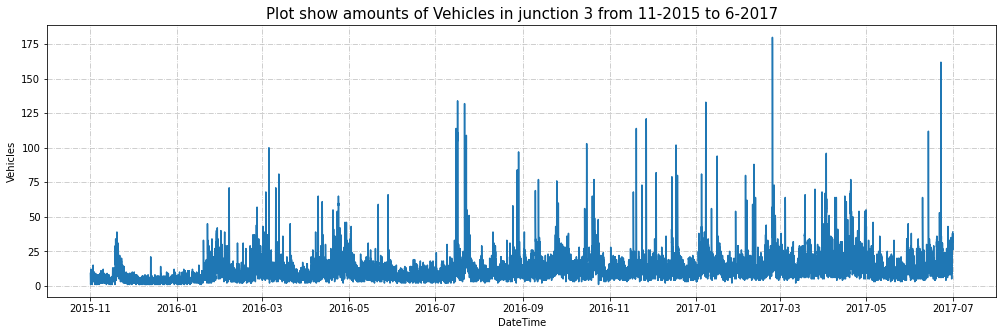

In [55]:
td_time_series_plot(3)

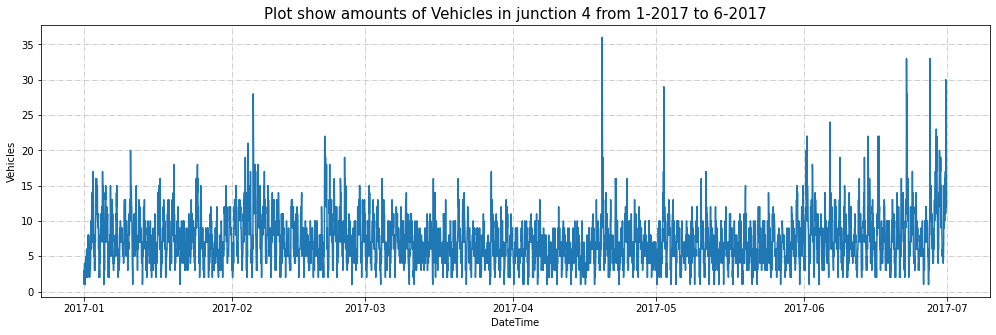

In [56]:
td_time_series_plot(4)

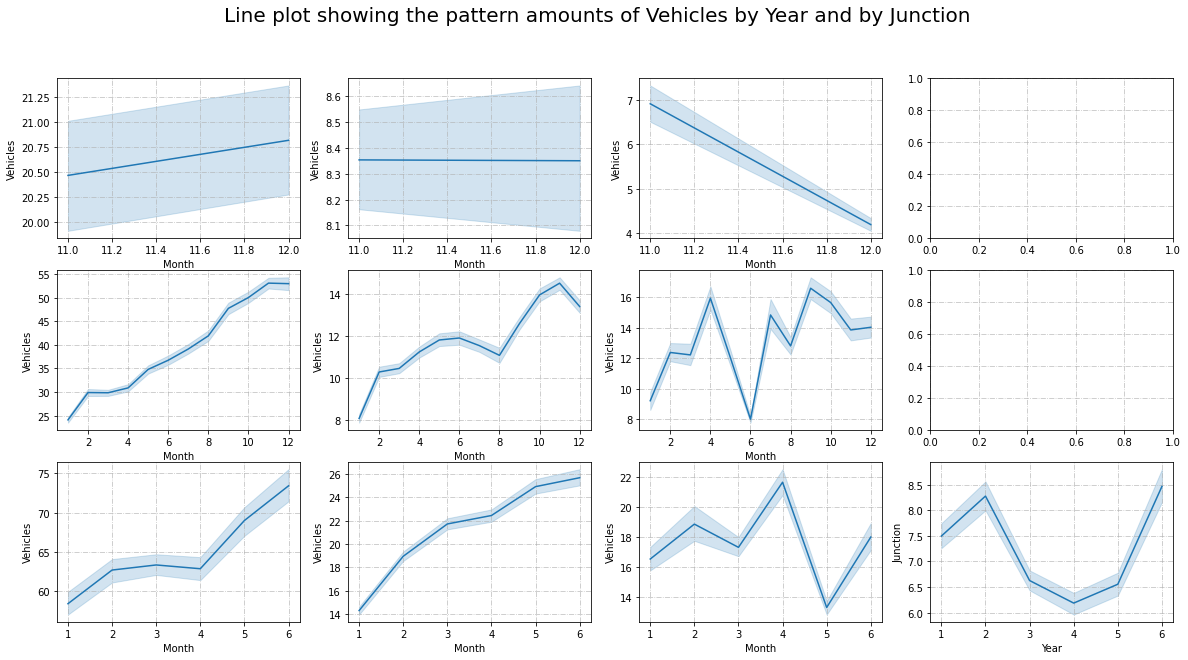

In [57]:
f, ax = plt.subplots(3, 4, figsize=(20, 10))

for i, year in enumerate(range(2015, 2018)):
    for j, junction in enumerate(range(1, 5)):
        sns.lineplot(data=df[(df.Junction == junction) & (df.Year == year)], x='Month', y='Vehicles', ax=ax[i, j])
        ax[i, j].grid(True, alpha=0.75, ls='-.')

plt.xlabel('Year')
plt.ylabel('Junction')
f.suptitle('Line plot showing the pattern amounts of Vehicles by Year and by Junction', fontsize=20)
plt.show()

Yearly, there has been an upward trend for all junctions except for the fourth junction. As we already established above that the fourth junction has limited data and that don't span over a year.

We can see that there is an influx in the first and second junctions around June. I presume this may be due to summer break and activities around the same.

Monthly, throughout all the dates there is a good consistency in data.

For a day, we can see that are peaks during morning and evening times and a decline during night hours. This is as per expectation.

For weekly patterns, Sundays enjoy smoother traffic as there are lesser vehicles on roads. Whereas Monday to Friday the traffic is steady.

In [58]:
def get_list_traffic(dataf, drop=[]):
  # drop cột DateTime ở các data
    for i in drop:
        try:
            dataf.drop(drop, axis=1, inplace=True)
        except:
            print(f"{i} doesn't has in data")
      # create a list of dataframe has the data in that junction and remove the junction identify
    dataf = [dataf[dataf.Junction == i].drop('Junction', axis=1) for i in range(5)]
    return dataf

In [59]:
df1= df.set_index('DateTime')
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48120 entries, 2015-11-01 00:00:00+00:00 to 2017-06-30 23:00:00+00:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Junction      48120 non-null  int64 
 1   Vehicles      48120 non-null  int64 
 2   ID            48120 non-null  int64 
 3   Year          48120 non-null  int64 
 4   Month         48120 non-null  int64 
 5   day_of_month  48120 non-null  int64 
 6   day_of_week   48120 non-null  int64 
 7   Date          48120 non-null  object
 8   Time          48120 non-null  int64 
 9   day_of_year   48120 non-null  int64 
 10  Seconds       48120 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 4.4+ MB


In [60]:
traffic = get_list_traffic(df1)
for i in traffic:
    print(i.head(1))

Empty DataFrame
Columns: [Vehicles, ID, Year, Month, day_of_month, day_of_week, Date, Time, day_of_year, Seconds]
Index: []
                           Vehicles           ID  Year  Month  day_of_month  \
DateTime                                                                      
2015-11-01 00:00:00+00:00        15  20151101001  2015     11             1   

                           day_of_week        Date  Time  day_of_year  Seconds  
DateTime                                                                        
2015-11-01 00:00:00+00:00            6  2015-11-01     0          305        0  
                           Vehicles           ID  Year  Month  day_of_month  \
DateTime                                                                      
2015-11-01 00:00:00+00:00         6  20151101002  2015     11             1   

                           day_of_week        Date  Time  day_of_year  Seconds  
DateTime                                                                    

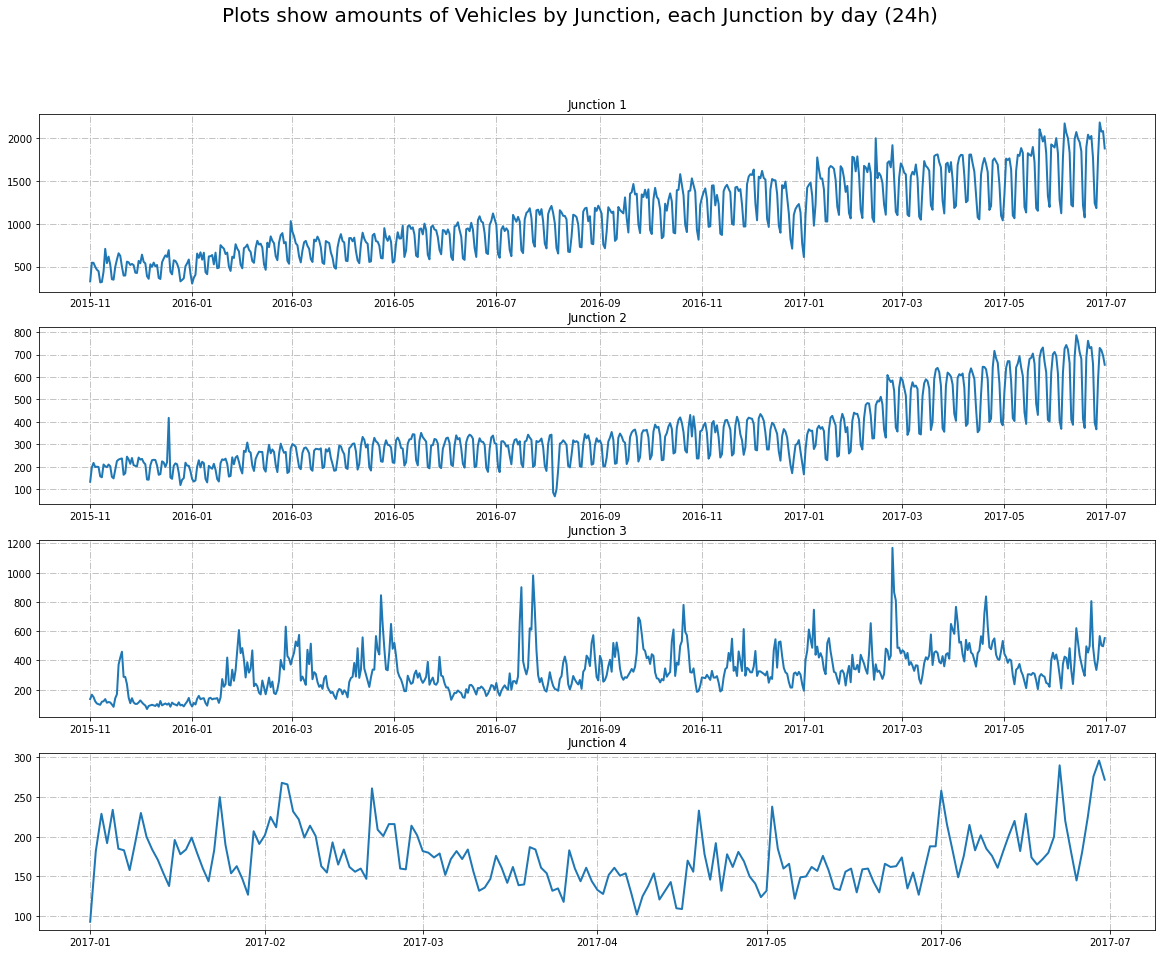

In [61]:
f, ax = plt.subplots(nrows=4, figsize=(20, 15))
for i in range(4):
    ax[i].plot(traffic[i + 1].resample('D').mean().Vehicles, label=f'Vehicles of {i + 1} Junction', lw=2)
    ax[i].grid(True, alpha=0.75, lw=1, ls='-.')
    ax[i].set_title(f'Junction {i + 1}')
f.suptitle('Plots show amounts of Vehicles by Junction, each Junction by day (24h)', fontsize=20);

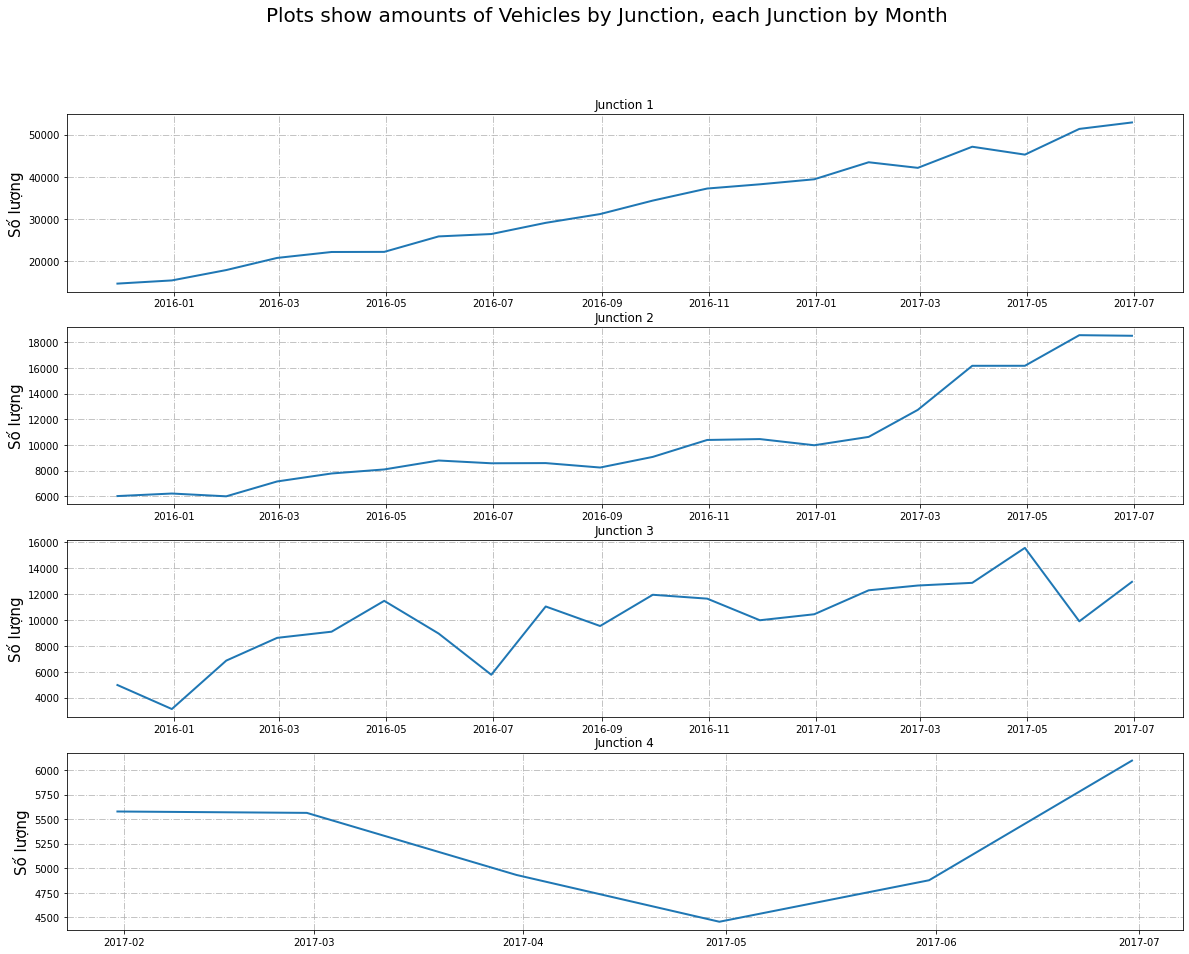

In [62]:
f, ax = plt.subplots(nrows=4, figsize=(20, 15))
for i in range(4):
    ax[i].plot(traffic[i + 1].resample('M').mean().Vehicles, label=f'Vehicles of {i + 1} Junction', lw=2)
    ax[i].grid(True, alpha=0.75, lw=1, ls='-.')
    ax[i].set_ylabel('Số lượng', fontsize=15)
    ax[i].set_title(f'Junction {i + 1}')
f.suptitle('Plots show amounts of Vehicles by Junction, each Junction by Month', fontsize=20);

It can be seen here that the first junction is visibly having an upward trend.
The data for the fourth junction is sparse starting only after 2017
Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.

### COMMENT ON THE ABOVE DATA ANALYSIS

From the above data analysis and visualization, the following conclusion is deduced;
1. Junction 1 had the highest vehicular movements of all the Four Junction under consideration, Junction 2 and 3 had similar volumes
2. Junction 1 had steady increase in vehicular movement overtime while Junction 2 had fluctuating vehicular movement with highest movement experienced in March 2017, Junction 3 had quite a constant movement over time Much can not be said about junction 4 as it begin operation in 2017.
3. Even though no vehicular movement was recorded for junction 4 until 2017, All other junctions recorded highest movement in 2016
4. Every Junction record low vehicular movement towards the end of the month
5. With the exception of junction 4, there seems to be high traffic movement at 11am and 7pm for all the junctions with 7pm have a slight edge over the later.

 - There has been upward trend of vehicles yearly in all the four junctions with juction higher the highesrt upward trend
 
 - We notice an increase in the first and third juction around the month of June, this might be due to summer activities that happen around that time.
 
 - We notice a daily increase in the number of vehicles in all the junctions except junction four which started recording data from January 2017.
 
 - We notice the data increasing during the morning time, around 6am, stays steady throughout the afternoon, and decreases during the evening time around 8pm.
 
 - We also notice that we have less traffic during the weekend and steady traffic during the weekdays.